## Раздел "1.3 Основы синтаксиса и структур Python"

##  Практическая работа №2 Основы Python

### Задание 1.
Необходимо спарсить данные о вакансиях python разработчиков с сайта hh.ru, введя в поиск “python разработчик” и указав, что мы рассматриваем все регионы. Необходимо спарсить:

Название вакансии  
Требуемый опыт работы  
Заработную плату  
Регион  
И сохранить эти данные в формате json в следующем виде:
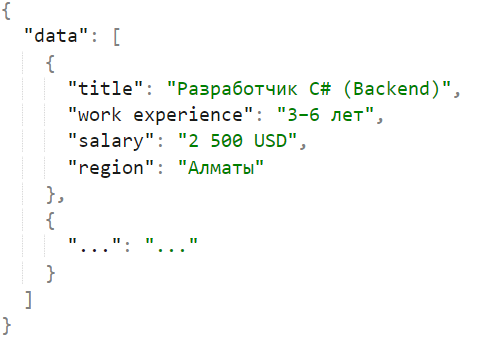

In [72]:
import requests
import json
from tqdm import tqdm
import time
import random
import re
from bs4 import BeautifulSoup

#### Решение 1 с помощью библиотеки `bs4`

In [87]:
url = 'https://hh.ru/search/vacancy?text=python+разработчик&area=113'

links = []
for page in tqdm(range(20)):
    resp = requests.get(f'{url}&page={page}', headers={'user-agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(resp.text, 'lxml')
    resp.close()
    items = soup.find_all(class_='vacancy-serp-item-body')
    for item in items:
        link = item.find(attrs={'data-qa': "serp-item__title"})['href']
        links.append(re.search('https://hh.ru/vacancy/\d+', link)[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:22<00:00,  1.11s/it]


In [ ]:
result = {}
result['data'] = []
for link in tqdm(links):
    resp = requests.get(link, headers={'user-agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(resp.text, 'lxml')
    resp.close()
    title = soup.find(attrs={'data-qa': "vacancy-title"})
    exp = soup.find(attrs={'data-qa': "vacancy-experience"})
    salary = soup.find(attrs={'data-qa': "vacancy-salary"})
    region = soup.find(attrs={'data-qa': "vacancy-serp__vacancy-address"})
    result['data'].append({
        'title': title.text.replace('\xa0', ' ') if title else None,
        'work experience': exp.text.replace('\xa0', ' ') if exp else None,
        'salary': salary.text.replace('\xa0', ' ') if salary else None,
        'region': region.text.replace('\xa0', ' ') if region else None
    })
    time.sleep(random.randint(2,5))

In [136]:
# Сохранение результатов в json формате
with open('data.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, ensure_ascii=False, indent=4)

#### Решение 2 с помощью библиотеки `requests` и API hh.ru https://github.com/hhru/api/

In [63]:
# Поиск по вакансиям через API hh.ru
page = 0
ids = []
while True:
    req = requests.get(
        'https://api.hh.ru/vacancies',
        params={
            'area': 113,
            'text': 'python разработчик',
            'search_field': 'name',
            'per_page': 100,
            'page': page
        }
    )
    data = req.content.decode()
    req.close()
    data_dict = json.loads(data)
    ids += [item['id'] for item in data_dict['items']]
    if len(data_dict['items']) < 100:
        break
    page += 1

764


In [68]:
# Выгрузка данных для найденных вакансий через API hh.ru
result = {}
result['data'] = []
for vacancy_id in tqdm(ids):
    req = requests.get(
        'https://api.hh.ru/vacancies/' + vacancy_id
    )
    data = req.content.decode()
    req.close()
    item = json.loads(data)
    result['data'].append({
        'title': item['name'],
        'work experience': item['experience']['name'],
        'salary': item['salary'],
        'region': item['area']['name']
    })

100%|████████████████████████████████████████████████████████████████████████████████| 764/764 [03:37<00:00,  3.51it/s]


In [76]:
# Отображение зарплаты в более удобном виде для чтения
for d in result['data']:
    if d['salary']:
        lb = d['salary']['from']
        ub = d['salary']['to']
        cur = d['salary']['currency']
        if lb and ub: 
            d['salary'] = f'От {lb} до {ub} {cur}'
        if lb:
            d['salary'] = f'От {lb} {cur}'
        if ub:
            d['salary'] = f'До {ub} {cur}'

In [90]:
# Сохранение результатов в json формате
with open('data2.json', 'w', encoding='utf-8') as file:
    json.dump(result, file, ensure_ascii=False, indent=4)

### Задание 2. Палиндром строки
Дана строка X, возвращайте True, если X является палиндромом.

Строка является палиндромом тогда, когда она читается одинаково как в обратном, так и в прямом направлении.

Например, является “taco cat” является палиндромом, в то время как “black cat” не является.
В данной задаче пробелы не учитываются.

Гарантируется, что исходная строка может содержать символы только нижнего регистра.

#### Решение 1

In [94]:
def is_palindrome_1(a):
    b = ''.join(a.split())
    return b == b[::-1]

In [96]:
examples = ['"taco cat"', '"rotator"', '"black cat"']
for example in examples:
    print(example, is_palindrome_1(example))

"taco cat" True
"rotator" True
"black cat" False


#### Решение 2

In [97]:
def is_palindrome_2(a):
    b = a.replace(' ', '')
    return b == b[::-1]

In [98]:
examples = ['"taco cat"', '"rotator"', '"black cat"']
for example in examples:
    print(example, is_palindrome_2(example))

"taco cat" True
"rotator" True
"black cat" False


### Задание 3. Перевод арабского числа в римское
Дано целое положительное число X, необходимо вывести вариант этого числа в римской системе счисления в формате строки.
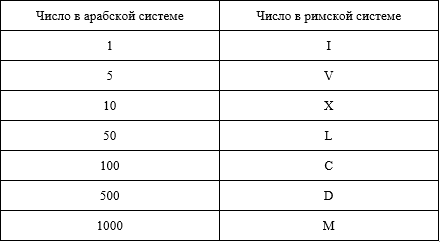
Римские числа записываются от наибольшего числа к наименьшему слева направо.

Однако число 4 не является “IIII”. Вместо этого число 4 записывается, как “IV”. Т.к. 1 стоит перед 5, мы вычитаем 1, делая 4. Тот же принцип применим к числу 9, которое записывается как “IX”.

Случаи, когда используется вычитание:

I может быть помещен перед V и X, чтобы сделать 4 и 9.

X может быть помещен перед L и C, чтобы составить 40 и 90.

C может быть помещен перед D и M, чтобы составить 400 и 900.

#### Решение

In [198]:
# Функция, которая возвращает значение множителя
# для заданного разряда в заданном числе
def digits(number, n):
    """
    number - заданное число
    n - номер разряда, начиная с нулевого
    """
    return int((number % 10**(n + 1) - number % 10**n) / 10**n)

In [199]:
# Словарь, который содержит римские обозначения для 
# значений 1 и 5 соответствующих номеров разряда
dic = {
    0: {'1': 'I', '5': 'V'},
    1: {'1': 'X', '5': 'L'},
    2: {'1': 'C', '5': 'D'},
    3: {'1': 'M'}
}

In [200]:
# Функция, которая подставляет римское обозначение из словаря
# для заданного номера разряда и значения множителя
def mapping(dic, digit, value):
    if value >= 1 and value <= 3:
        return value * dic[digit]['1']
    elif value == 4:
        return dic[digit]['1'] + dic[digit]['5']
    elif value >= 5 and value <= 8:
        return dic[digit]['5'] + (value - 5) * dic[digit]['1']
    elif value == 9:
        return dic[digit]['1'] + dic[digit + 1]['1']
    elif value == 0:
        return ''

In [201]:
# Функция, которая делает преобразование из арабской записи в римскую
def roman(arabic_number):
    roman_number = ''
    for i in [3, 2, 1, 0]:
        value = digits(arabic_number, i)
        roman_number += mapping(dic, i, value)
    return roman_number

In [207]:
examples = [3, 9, 1945, 40, 90, 6, 7, 400, 2000]
for example in examples:
    print(example, '"' + roman(example) + '"')

3 "III"
9 "IX"
1945 "MCMXLV"
40 "XL"
90 "XC"
6 "VI"
7 "VII"
400 "CD"
2000 "MM"


### Задание 4. Валидность скобок

Дана строка X, состоящая только из символов “{“, “}”, “[“, “]”, “(“, “)”. Программа должна вывести True, в том случае если все открытые скобки закрыты. Например: “[()]{}”, все открытые скобки закрыты закрывающимися скобками, потому вывод будет True. В случае же, если строка будет похожа на: “{{{}”, то вывод будет False, т.к. не все открытые скобки закрыты.

#### Решение

In [213]:
def check_string(string):
    dic = {'{': 0, '}': 0, '[': 0, ']': 0, '(': 0, ')': 0}
    for s in string:
        dic[s] += 1
        if dic['{'] < dic['}'] or dic['['] < dic[']'] or dic['('] < dic[')']:
            return False
    if dic['{'] != dic['}'] or dic['['] != dic[']'] or dic['('] != dic[')']:
        return False
    else:
        return True

In [215]:
examples = ['[{}({})]', '{]', '{', '{[}]', '}{']
for example in examples:
    print(example, check_string(example))

[{}({})] True
{] False
{ False
{[}] True
}{ False


### Задание 5. Умножить два бинарных числа в формате строк

На вход подаются две строки X1 и X2, содержащие бинарные числа.

Необходимо вывести их бинарное произведение в формате строки.

#### Решение

In [2]:
# Функция, которая принимает две строки, содержащие бинарные числа
# и возвращает бинарное произведение в формате строки
def bin_mult(s1, s2):
    return format(int(s1, 2) * int(s2, 2), 'b')

In [6]:
examples = [('111', '101'), ('110', '10'), ('1001', '1100')]
for example in examples:
    print(' * '.join(example), '=', bin_mult(*example))

111 * 101 = 100011
110 * 10 = 1100
1001 * 1100 = 1101100
